# Sinkhorn divergence gradient flows

Let $\mathrm{OT_\varepsilon}(\alpha, \beta)$ the entropic regularized OT distance between two distributions $\alpha$ and $\beta$. One issue with $\mathrm{OT_\varepsilon}$ is that $\mathrm{OT_\varepsilon}(\alpha, \alpha)$ is not equal to 0.

The Sinkhorn divergence, defined in {cite}`genevay:18` as $\mathrm{S}_\varepsilon(\alpha, \beta) = \mathrm{OT_\varepsilon}(\alpha, \beta) - \frac{1}{2}\mathrm{OT_\varepsilon}(\alpha, \alpha) - \frac{1}{2}\mathrm{OT_\varepsilon}(\beta, \beta)$ removes this entropic bias.

In this tutorial we showcase the advantage of removing the entropic bias using gradient flows on 2-D distributions, as done in {cite}`feydy:19` and following the {doc}`point_clouds` tutorial.

## Imports

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Defining two distributions

Let us start by defining simple source and target distributions.

In [2]:
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)

# Let us define a small distribution.
x = 0.5 * jax.random.normal(key1, (25, 2))

# And a slightly bigger one.
y = jax.random.normal(key2, (50, 2)) + jnp.array((6, 0))

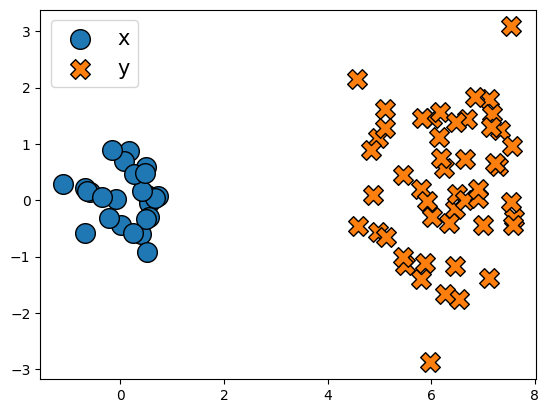

In [3]:
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=200)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=200)
plt.legend(fontsize=15)
plt.show()

## Gradient flow with $\mathrm{OT}_\varepsilon$

As in the {doc}`point_clouds` tutorial, we now compute the gradient flow for the regularized OT cost using the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm.

The code below performs gradient descent to move the points of $x$ in a way that minimizes the regularized OT cost.

In [4]:
def optimize_reg_ot(
    x: jnp.ndarray,
    y: jnp.ndarray,
    num_iter: int = 300,
    lr: float = 0.2,
    dump_every: int = 50,
    epsilon: float = 2.0,
):
    """Compute a gradient flow for the regularized OT cost."""

    ots = []

    # Wrapper function that returns OT cost and OT output given a geometry.
    def reg_ot_cost(geom):
        ot = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
        return ot.reg_ot_cost, ot

    # Apply jax.value_and_grad operator and jit that function.
    reg_ot_cost_vg = jax.jit(jax.value_and_grad(reg_ot_cost, has_aux=True))

    # Perform gradient descent on `x`.
    for i in range(0, num_iter + 1):
        # Define the geometry, then compute the OT cost and its gradient.
        geom = pointcloud.PointCloud(x, y, epsilon=epsilon)
        (reg_ot_cost, ot), geom_g = reg_ot_cost_vg(geom)
        assert ot.converged

        x = x - geom_g.x * lr  # Perform a gradient descent step.
        if i % dump_every == 0:
            ots.append(ot)  # Save the current state of the optimization.

    return ots

In [5]:
# Compute a gradient flow for the regularized OT cost.
ots = optimize_reg_ot(x, y, num_iter=500, lr=0.2, epsilon=2, dump_every=50)

As you can see, the distribution collapses to a thin strip. Let us fix this using the debiased quantity $\mathrm{S}_\varepsilon$.

In [6]:
# Display an animation of the optimization.
fig = plt.figure(figsize=(8, 5))
plott = plot.Plot(fig=fig, show_lines=False)
anim = plott.animate(ots, frame_rate=4)
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

## Gradient flow with $\mathrm{S}_\varepsilon$

By slightly adapting the previous function, we can compute the gradient flow using the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` instead of the regularized OT cost.

In [7]:
def optimize_sink_div(
    x: jnp.ndarray,
    y: jnp.ndarray,
    num_iter: int = 300,
    lr: float = 0.2,
    dump_every: int = 50,
    epsilon: float = 2.0,
):
    """Compute a gradient flow for the Sinkhorn divergence."""

    ots = []

    # Wrapper function that returns OT cost and OT output given a geometry.
    def reg_ot_cost(geom):
        ot = sinkhorn_divergence.sinkhorn_divergence(geom, x=geom.x, y=geom.y)
        return ot.divergence, ot

    # Apply jax.value_and_grad operator and jit that function.
    reg_ot_cost_vg = jax.jit(jax.value_and_grad(reg_ot_cost, has_aux=True))

    # Run a naive, fixed stepsize, gradient descent on locations `x`.
    for i in range(0, num_iter + 1):
        # Define the geometry, then compute the OT cost and its gradient.
        geom = pointcloud.PointCloud(x, y, epsilon=epsilon)
        (reg_ot_cost, ot), geom_g = reg_ot_cost_vg(geom)
        assert ot.converged

        x = x - geom_g.x * lr  # Perform a gradient descent step.
        if i % dump_every == 0:
            ots.append(ot)  # Save the current state of the optimization.

    return ots

In [8]:
# Compute a gradient flow for the Sinkhorn divergence.
ots = optimize_sink_div(x, y, num_iter=500, lr=0.2, epsilon=2, dump_every=50)

Thanks to the debiasing, the distributions overlap nicely.

In [9]:
# Here, we have to adapt the plotting object slightly to accomodate for the fact
# that we have Sinkhorn divergence outputs, which have multiple geometries.
class CustomPlot(plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y


# Display an animation of the optimization.
fig = plt.figure(figsize=(8, 5))
plott = CustomPlot(fig=fig, show_lines=False)
anim = plott.animate(ots, frame_rate=4)
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()